In [1]:
import cv2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from skimage import data, io, filters
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage.feature import hog 
from skimage.transform import resize

In [4]:
import pickle
import numpy as np
import pandas as pd

import glob
import random
import csv
from os import listdir
from os.path import isfile, join

In [5]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB
import pandas as pd
import io

In [6]:
data_directory = '../data/hands/'

In [7]:
user_list = ['user_10', 'user_3', 'user_4', 'user_5', 'user_6', 'user_7', 'user_9']

In [8]:
def train_binary(train_list, data_directory):
    
    frame = pd.DataFrame()
    list_ = []
    for user in train_list:
        list_.append(pd.read_csv(data_directory + user + '/' + user + '_loc.csv', index_col=None, header=0))
        
    frame = pd.concat(list_)
    #print (frame)
    frame['side'] = frame['bottom_right_x']-frame['top_left_x']
    frame['hand'] = 1

    print ('Unique frames: %s' % frame.image.unique())

    imageset = getfiles(data_directory, frame.image.unique())

    #returns actual images and dataframe 
    return imageset, frame

In [9]:
#given a list of filenames return s a dictionary of images 
def getfiles(data_directory, filenames):
    dir_files = {}
    for x in filenames:
        filename = '%s/%s' % (data_directory, x)
        
        dir_files[x] = cv2.imread(filename)
    return dir_files

In [10]:
image_set, df = train_binary(user_list, data_directory)

Unique frames: ['user_10/A0.jpg' 'user_10/A1.jpg' 'user_10/A2.jpg' ..., 'user_9/Y7.jpg'
 'user_9/Y8.jpg' 'user_9/Y9.jpg']


In [11]:
# image_set['user_10/A0.jpg']
df.hand.value_counts() # All hands

1    1680
Name: hand, dtype: int64

In [12]:
df.head(2)

,image,top_left_x,top_left_y,bottom_right_x,bottom_right_y,side,hand
0,user_10/A0.jpg,186,84,286,184,100,1
1,user_10/A1.jpg,186,84,286,184,100,1


In [13]:
#return hog of a particular image vector
def convertToGrayToHOG(imgVector):
    rgbImage = rgb2gray(imgVector)
    return hog(rgbImage)

In [14]:
def buildhandnothand_lis(frame, imgset):
    
    poslis =[]
    neglis =[]
    for nameimg in frame.image:
        tupl = frame[frame['image']==nameimg].values[0]
        x_tl = tupl[1]
        y_tl = tupl[2]
        side = tupl[5]
        conf = 0
        
        dic = [0, 0]
        
        arg1 = [x_tl,y_tl,conf,side,side]
        poslis.append(convertToGrayToHOG(crop(imgset[nameimg],x_tl,x_tl+side,y_tl,y_tl+side)))
        while dic[0] <= 1 or dic[1] < 1:
            x = random.randint(0,320-side)
            y = random.randint(0,240-side) 
            crp = crop(imgset[nameimg],x,x+side,y,y+side)
            hogv = convertToGrayToHOG(crp)
            arg2 = [x,y, conf, side, side]
            
            z = overlapping_area(arg1,arg2)
            if dic[0] <= 1 and z <= 0.5:
                neglis.append(hogv)
                dic[0] += 1
            if dic[0]== 1:
                break
    label_1 = [1 for i in range(0,len(poslis)) ]
    label_0 = [0 for i in range(0,len(neglis))]
    label_1.extend(label_0)
    poslis.extend(neglis)
    return poslis,label_1

In [15]:
#takes returns cropped image 
def crop(img, x1, x2, y1, y2):
    crp=img[y1:y2, x1:x2]
    crp=resize(crp, ((128,128))) #resize
    return crp

In [16]:
#utility funtcion to compute area of overlap
def overlapping_area(detection_1, detection_2):
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[3]
    x2_br = detection_2[0] + detection_2[3]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[4]
    y2_br = detection_2[1] + detection_2[4]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[3] * detection_2[4]
    area_2 = detection_2[3] * detection_2[4]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

In [17]:
z = buildhandnothand_lis(df, image_set)

/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [18]:
z[0]

[array([ 0.06959381,  0.01554301,  0.02363114, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.06124146,  0.0163716 ,  0.02525483, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.09496679,  0.0164323 ,  0.02750747, ...,  0.        ,
         0.00031167,  0.        ]),
 array([ 0.06134381,  0.01375027,  0.02300072, ...,  0.00064264,
         0.00483669,  0.00259808]),
 array([ 0.0289681 ,  0.02990331,  0.0409313 , ...,  0.00500508,
         0.0192922 ,  0.05569076]),
 array([ 0.09559663,  0.0145166 ,  0.02161371, ...,  0.00178248,
         0.00097817,  0.04007515]),
 array([ 0.08493911,  0.02194829,  0.01851424, ...,  0.00565067,
         0.00236279,  0.06386312]),
 array([ 0.07191316,  0.01211939,  0.02393366, ...,  0.00356593,
         0.00949984,  0.10691469]),
 array([ 0.07640888,  0.01484057,  0.02443028, ...,  0.00319707,
         0.00077168,  0.06820894]),
 array([ 0.08351903,  0.0292667 ,  0.03094735, ...,  0.        ,
         0.        ,  0.  

In [19]:
from collections import Counter
Counter(z[1])
#print (z[1])

Counter({0: 1680, 1: 1680})

In [20]:
#Classifier
imageset, boundbox, hog_list, label_list = image_set, df, z[0], z[1] # Imageset, boundbox, hog_list,label_list Loaded

boundbox.iloc[1]
print (boundbox.iloc[0])

image             user_10/A0.jpg
top_left_x                   186
top_left_y                    84
bottom_right_x               286
bottom_right_y               184
side                         100
hand                           1
Name: 0, dtype: object


In [22]:
#for a in df.image:
#    print (a)

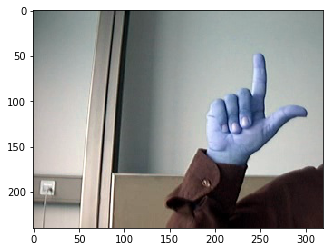

In [25]:
image_index=100
image = cv2.imread(data_directory + str(boundbox.iloc[image_index][0]))
plt.imshow(image)

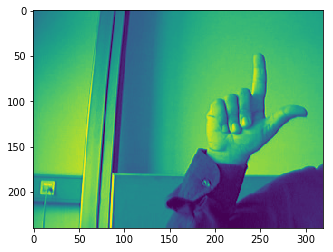

In [26]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image)

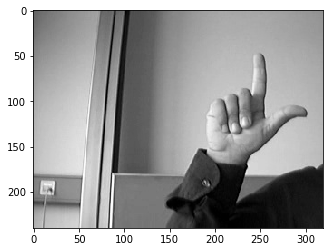

In [27]:
plt.imshow(gray_image, cmap='gray')

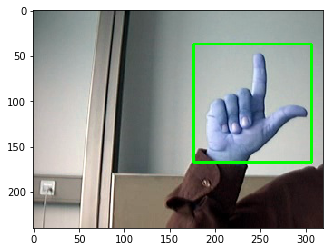

In [28]:
clone = image.copy()
rect = cv2.rectangle(clone, 
              (int(boundbox.iloc[image_index][1]), int(boundbox.iloc[image_index][2])), 
              (int(boundbox.iloc[image_index][3]), int(boundbox.iloc[image_index][4])), 
              (0, 255, 0), 2)
plt.imshow(rect)

user_10/L0.jpg


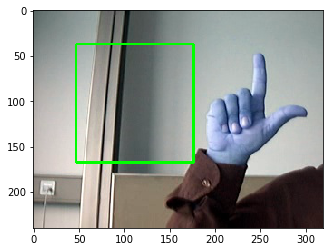

In [29]:
clone = image.copy()
rect = cv2.rectangle(clone, 
              (int(boundbox.iloc[image_index][1]-boundbox.iloc[image_index][5] ), int(boundbox.iloc[image_index][2])), 
              (int(boundbox.iloc[image_index][3]-boundbox.iloc[image_index][5]), int(boundbox.iloc[image_index][4])), 
              (0, 255, 0), 2)
plt.imshow(rect)
print (boundbox.iloc[image_index][0])

In [41]:
output_directory = '../data/hand-no-hand/'

In [35]:
handpos = crop(imageset[boundbox.iloc[image_index][0]], 
               int(boundbox.iloc[image_index][1]), 
               int(boundbox.iloc[image_index][3]), 
               int(boundbox.iloc[image_index][2]), 
               int(boundbox.iloc[image_index][4]))

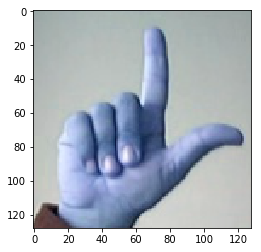

In [36]:
plt.imshow(handpos)

In [42]:
import os
filename = os.path.join(output_directory, 'positive', str(image_index) + '.jpg')

In [43]:
cv2.imwrite(filename, handpos)

True

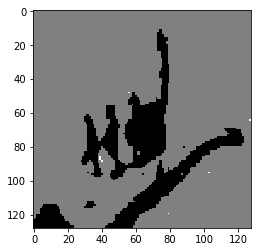

In [45]:
image = cv2.imread(filename)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')

In [ ]:
handpos_gray = cv2.cvtColor(handpos, cv2.COLOR_BGR2GRAY)

In [ ]:
plt.imsave(, handpos_gray))
plt.imshow(handpos_gray)

In [33]:
type(handpos)
handpos.shape

(128, 128, 3)

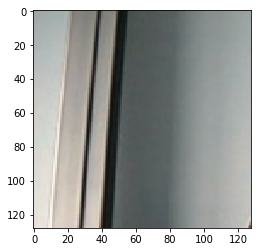

In [195]:
handneg =crop(imageset[boundbox.iloc[image_index][0]],int(boundbox.iloc[image_index][1]-boundbox.iloc[image_index][5]), int(boundbox.iloc[image_index][3]-boundbox.iloc[image_index][5]),int(boundbox.iloc[image_index][2]),int(boundbox.iloc[image_index][4]))
plt.imsave('C://Users//Clare//Documents//SignHands//dataset//generated_images2//negative//'+str(image_index)+'.jpg', handneg)
plt.imshow(handneg)


In [200]:
for image_index in range(0,len(boundbox)):
#image_index=1
    image = cv2.imread('C://Users//Clare//Documents//SignHands//dataset//'+str(boundbox.iloc[image_index][0]))

    handpos =crop(imageset[boundbox.iloc[image_index][0]],int(boundbox.iloc[image_index][1]), int(boundbox.iloc[image_index][3]),int(boundbox.iloc[image_index][2]),int(boundbox.iloc[image_index][4]))
    plt.imsave('C://Users//Clare//Documents//SignHands//dataset//generated_images2//positive//'+str(image_index)+'.jpg', handpos, cmap=plt.cm.gray)

    try:
        '''left'''
        handneg =crop(imageset[boundbox.iloc[image_index][0]],int(boundbox.iloc[image_index][1]-boundbox.iloc[image_index][5]), int(boundbox.iloc[image_index][3]-boundbox.iloc[image_index][5]),int(boundbox.iloc[image_index][2]),int(boundbox.iloc[image_index][4]))
        plt.imsave('C://Users//Clare//Documents//SignHands//dataset//generated_images2//negative//L'+str(image_index)+'.jpg', handneg, cmap=plt.cm.gray)
            
    except ValueError:
        handneg =crop(imageset[boundbox.iloc[image_index][0]],int(boundbox.iloc[image_index][1]+boundbox.iloc[image_index][5]), int(boundbox.iloc[image_index][3]+boundbox.iloc[image_index][5]),int(boundbox.iloc[image_index][2]),int(boundbox.iloc[image_index][4]))
        plt.imsave('C://Users//Clare//Documents//SignHands//dataset//generated_images2//negative//R_'+str(image_index)+'.jpg', handneg, cmap=plt.cm.gray)
       

In [198]:
try:
    '''right'''
    handneg =crop(imageset[boundbox.iloc[image_index][0]],int(boundbox.iloc[image_index][1]+boundbox.iloc[image_index][5]), int(boundbox.iloc[image_index][3]+boundbox.iloc[image_index][5]),int(boundbox.iloc[image_index][2]),int(boundbox.iloc[image_index][4]))
    plt.imsave('C://Users//Clare//Documents//SignHands//dataset//generated_images//negative//R_'+str(image_index)+'.jpg', handneg,cmap=plt.cm.gray)
except ValueError:
    print (image_index)
    
    '''down'''
    handneg =crop(imageset[boundbox.iloc[image_index][0]],int(boundbox.iloc[image_index][1]), int(boundbox.iloc[image_index][3]),int(boundbox.iloc[image_index][2]+boundbox.iloc[image_index][5]),int(boundbox.iloc[image_index][4]+boundbox.iloc[image_index][5]))
    plt.imsave('C://Users//Clare//Documents//SignHands//dataset//generated_images//negative//D_'+str(image_index)+'.jpg', handneg,cmap=plt.cm.gray)

    '''up'''
    handneg =crop(imageset[boundbox.iloc[image_index][0]],int(boundbox.iloc[image_index][1]), int(boundbox.iloc[image_index][3]),int(boundbox.iloc[image_index][2]-boundbox.iloc[image_index][5]),int(boundbox.iloc[image_index][4]-boundbox.iloc[image_index][5]))
    plt.imsave('C://Users//Clare//Documents//SignHands//dataset//generated_images//negative//D_'+str(image_index)+'.jpg', handneg,cmap=plt.cm.gray)
